In [1]:
import numpy as np
import pandas as pd
import json
import os
import sys

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.cluster import KMeans

from tqdm import tqdm
import shutil

## Load the Data

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!unzip -q ./gdrive/MyDrive/data_bb1_img_recognition.zip -d .

In [4]:
# load data
LOADPATH = './train/'
SAVEPATH = './models/'
df = pd.read_csv('labels.csv')
df.head()

FileNotFoundError: ignored

# Clustering

In [ ]:
model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


In [ ]:
from pathlib import Path

imgs = [image.load_img(Path("train") / fname, target_size=(128, 128)) for fname in df["name"]]

In [ ]:
img_array = np.array([img_to_array(img) for img in imgs])
preprocessed = preprocess_input(img_array)

In [ ]:
preprocessed.shape

In [ ]:
preds = model.predict(preprocessed)

In [ ]:
vector_preds = preds.reshape(preds.shape[0], -1)

np.save("gdrive/MyDrive/data/face_bounty_vec.npy", vector_preds)

In [5]:
!pip install umap-learn
import umap

vector_preds = np.load("gdrive/MyDrive/data/face_bounty_vec.npy")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 4.2 MB/s 
     |████████████████████████████████| 1.1 MB 44.4 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=c2cea2df1aedd3a91c4f3b74db12cb7897e9387049cee3b3e5c82408e4ae1fe6
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=45f08cd38a8912a042723bc76dda58b621d256af47e9316cd2763312930923c8
  Stored in directory: /root/.cache/pip/wheels/1c/63/3a/29954bca1a27ba100ed8c27973a78cb71b43dc67aed62e80c3
Successfully built umap-learn pynndescent


In [6]:
map = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=20,
    random_state=42,
)
print(f"{vector_preds.shape=}")
reduced_dat = map.fit_transform(vector_preds)

vector_preds.shape=(12283, 8192)


In [8]:
np.save("gdrive/MyDrive/data/umap_10d.npy", reduced_dat)

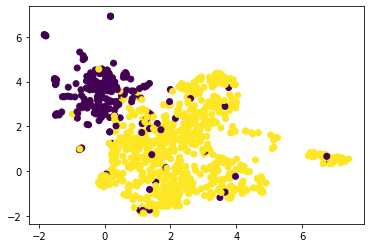

In [ ]:
import matplotlib.pyplot as plt

random_idx = np.random.randint(low=0, high=reduced_dat.shape[0], size=1000)
sample_dat = reduced_dat[random_idx, :]
sample_dat.shape
sample_face = df.loc[random_idx, "real_face"]

plt.scatter(sample_dat[:, 0], sample_dat[:, 1], c=sample_face)

## Gender

In [ ]:
k = 2
clusters_gender = KMeans(k, random_state = 40)
gender_model = clusters_gender.fit(img_features)


In [ ]:
df_clusters_gender = pd.DataFrame(df_cluster,columns=['name'])
df_clusters_gender["clusterid"] = clusters_gender.labels_

In [ ]:
df_real_gender = df[df["gender"].notna()][["name","gender"]]       
df_real_gender['gender'] = df_real_gender['gender'].replace(['female', 'male'],[1, 0]) # we revise these after calling retrieve_info

In [ ]:
df_comp_gender = pd.merge(df_real_gender, df_clusters_gender, on=['name'])
df_comp_gender['comparison_column'] = np.where(df_comp_gender["gender"] == df_comp_gender["clusterid"],1, 0)

In [ ]:
gender_clusters = df_comp_gender["clusterid"]
real_labels = df_comp_gender["gender"]

In [ ]:
retrieve_info(gender_clusters, real_labels)

[0 0 0 ... 1 0 1]
1
[1 1 1 ... 0 1 0]
1


{0: 1, 1: 1}

In [ ]:
df_comp_gender['comparison_column'].value_counts()

1    2237
0    2197
Name: comparison_column, dtype: int64

In [ ]:
accuracy_gender = len(df_comp_gender[df_comp_gender['comparison_column'] == 1])/len(df_comp_gender)
accuracy_gender

0.504510599909788

In [ ]:
disp_gender = disparity_score(df_comp_gender['gender'], df_comp_gender['clusterid'])
disp_gender

0.033323034823674824

## Age

In [ ]:
# age
k = 4
clusters_age = KMeans(k, random_state = 40)
clusters_age.fit(img_features)

KMeans(n_clusters=4, random_state=40)

In [ ]:
df_clusters_age = pd.DataFrame(df_cluster,columns=['name'])
df_clusters_age["clusterid"] = clusters_age.labels_

In [ ]:
df_real_age = df[df["age"].notna()][["name","age"]]       
df_real_age['age'] = df_real_age['age'].replace(['0_17', '18_30', '31_60', '61_100'],[0,1,2,3])

# we revise these after calling retrieve_info


In [ ]:
df_comp_age = pd.merge(df_real_age, df_clusters_age, on=['name'])
df_comp_age['comparison_column'] = np.where(df_comp_age["age"] == df_comp_age["clusterid"],1, 0)


In [ ]:
age_clusters = df_comp_age["clusterid"]
real_labels = df_comp_age["age"]

In [ ]:
retrieve_info(age_clusters, real_labels)

In [ ]:
df_comp_age['comparison_column'].value_counts()

0    2919
1    1515
Name: comparison_column, dtype: int64

In [ ]:
accuracy_age = len(df_comp_age[df_comp_age['comparison_column'] == 1])/len(df_comp_age)
accuracy_age

0.3416779431664411

In [ ]:
disp_age = disparity_score(df_comp_age['age'], df_comp_age['clusterid'])
disp_age

0.3548509718145732

# Skin Tone

In [ ]:
# skin tone
k = 10
clusters_age = KMeans(k, random_state = 40)
clusters_age.fit(img_features)

KMeans(n_clusters=4, random_state=40)

In [ ]:
# #on test data
# clusters_test = gender_model.predict(img_features_2)


In [ ]:
# df_test = pd.read_csv('test/labels.csv')

In [ ]:
df_clusters_skintone = pd.DataFrame(df_cluster,columns=['name'])
df_clusters_skintone["clusterid"] = clusters_skintone.labels_

In [ ]:
df_real_skintone = df[df["skin_tone"].notna()][["name","skin_tone"]]       
df_real_skintone['skin_tone'] = df_real_age['skin_tone'].replace(['monk_1', 'monk_2', 'monk_3', 'monk_4', 'monk_5', 'monk_6', 'monk_7', 'monk_8', 'monk_9', 'monk_10'],[0,1,2,3,4,5,6,7,8,9])

# we revise these after calling retrieve_info


In [ ]:
df_comp_skintone = pd.merge(df_real_skintone, df_clusters_skintone, on=['name'])
df_comp_skintone['comparison_column'] = np.where(df_comp_skintone["age"] == df_comp_skintone["clusterid"],1, 0)


In [ ]:
real_labels_clusters = df_comp_skintone["clusterid"]
real_labels = df_comp_skintone["skin_tone"]

In [ ]:
retrieve_info(skintone_clusters, real_labels)

In [ ]:
df_comp_skintone['comparison_column'].value_counts()

0    2919
1    1515
Name: comparison_column, dtype: int64

In [ ]:
accuracy_skintone = len(df_comp_skintone[df_comp_skintone['comparison_column'] == 1])/len(df_comp_skintone)
accuracy_skintone

0.3416779431664411

In [ ]:
disp_skintone = disparity_score(df_comp_skintone['age'], df_comp_skintone['clusterid'])
disp_skintone

0.3548509718145732

### On Test Data - incomplete

In [ ]:
df_test_gender = pd.DataFrame(columns=['name', 'cluster'])

In [ ]:
df_test = pd.read_csv('test/labels.csv')

In [ ]:
img_path_2=os.listdir('test')
img_features_2,img_name_2=image_feature(img_path_2, df_test, 'test')

In [ ]:
# direc=os.listdir('test')
# # print(direc)
# for i in tqdm(direc):
#     print('in here 1')
#     if ((i!=".DS_Store") & (i!=".ipynb_checkpoints") & (i!="labels.csv")):
# #         if (df_cluster['name'].str.contains(i).sum()):
#         print('in here 2') # debugging
#         fname='test'+'/'+i
#         print("this is the image name", i)
#         img=image.load_img(fname,target_size=(224,224))
#         x = img_to_array(img)
#         print(img.shape)
# #         print(len(x))
# #         x=np.expand_dims(x,axis=0)
# #         x=preprocess_input(x)
# #         x=x.flatten()
# # #         feat=model.predict(x)
# # #         feat=feat.flatten()
# # #         print(len(img))
#         cluster = gender_model.predict(img)
#         print(cluster)
#         df_test_gender.loc[len(df_test_gender)]=[fname, cluster]
#     else:
#         print('outside')